In [150]:
from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv
from typing import List, Tuple, Annotated, Sequence, Literal
from typing_extensions import TypedDict
from IPython.display import Image, display
import psycopg2
import os
import json
import re

load_dotenv()

OLLAMA_MODEL = "llama3.1:8b"
POSTGRES_PASSWORD = os.getenv("POSTGRES_PASSWORD")
POSTGRES_USER = os.getenv("POSTGRES_USER")
POSTGRES_DATABASE = os.getenv("POSTGRES_DATABASE")

OLLAMA_BASE_URL = "http://localhost:11434"

In [36]:
llm = ChatOllama(model=OLLAMA_MODEL, temperature=0, base_url=OLLAMA_BASE_URL)
llm_json = ChatOllama(model=OLLAMA_MODEL, temperature=0, format="json", base_url=OLLAMA_BASE_URL)

In [37]:
# Router

ROUTER_INSTRUCTIONS = '''You are an expert at determining whether a user question requires access to a database from a smartphone shop. 

The database schema is as follows:
- id (int): The unique identifier of the smartphone. You will not use this.
- brand (str): The brand of the smartphone, (eg. 'Apple', 'Google', 'Samsung'...)
- model (str): The model of the smartphone (eg. 'iPhone 13 Pro Max', 'Galaxy S21 Ultra', 'Mi 13 Pro'...)
- price (int): The price of the smartphone in Singapore Dollars.
- stock_status (str): The stock status of the smartphone ('In Stock', 'Out of Stock')

For questions related to a smartphone's price or availibility, you should accept the user query since it requires information from the database. For unknown brands or models, you should also approve the query since it may require database access. For all other questions that do not require database access, please reject the query.

Return JSON with a single key user_query, that is 'accept' or 'reject' depending on whether the question requires database access.'''

question = [HumanMessage(content="Hello, what is the price of the iphone 13 mini?")]

test_router_response = llm_json.invoke([SystemMessage(content=ROUTER_INSTRUCTIONS)] + question)

json.loads(test_router_response.content)

{'user_query': 'accept'}

In [50]:
@tool
def executePostgreSQLQuery(query: str) -> List:
    '''Executes a PostgreSQL query and returns the result as a list of tuples. Please only query the table "smartphones".
    
    Args:
        query (str): The PostgreSQL query to be executed.
        
    Returns:
        result (List): The result of the query, a list of tuples (id, brand, model, price, stock_status).
    '''

    # Connect to database
    #print("executePostgreSQLQuery tool called with query:", query)
    conn = psycopg2.connect(database=POSTGRES_DATABASE, user=POSTGRES_USER, password=POSTGRES_PASSWORD, host="localhost", port="5432")
    #print("Database connected successfully.")
    with conn.cursor() as cursor:
        try:
            #print("Executing sql query...")
            cursor.execute(query)
            result = cursor.fetchall()
        except:
            #print("Error executing query.")
            conn.close()
            return
    # Close connection
    conn.close()
    if result:
        #print("Database query success")
        return result
    else:
        return

In [39]:
# Database query

SQL_AGENT_INSTRUCTIONS = '''You are an agent designed to interact with a PostgreSQL database.

Given an input question, create a syntactically correct PostgreSQL query to run. Your query should always begin with "SELECT * FROM smartphones WHERE" and you can add any conditions you want. Note that all string comparisons should be match case-insensitive and enclosed within single quotes.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

The database schema is as follows:
- id (int): The unique identifier of the smartphone. You will not use this.
- brand (str): The brand of the smartphone, (eg. 'Apple', 'Google', 'Samsung'...)
- model (str): The model of the smartphone (eg. 'iPhone 13 Pro Max', 'Galaxy S21 Ultra', 'Mi 13 Pro'...)
- price (int): The price of the smartphone in Singapore Dollars.
- stock_status (str): The stock status of the smartphone ('In Stock', 'Out of Stock')
'''


question = [HumanMessage(content="Hello, what is the price of the iphone 13 mini?")]

llm_with_db = llm.bind_tools([executePostgreSQLQuery])

test_sql_agent_response = llm_with_db.invoke([SystemMessage(content=SQL_AGENT_INSTRUCTIONS)] + question)

tool_call_result = executePostgreSQLQuery.invoke(test_sql_agent_response.tool_calls[0]).content

tool_call_result

executePostgreSQLQuery tool called with query: SELECT * FROM smartphones WHERE brand = 'Apple' AND model = 'iPhone 13 Mini'
Database connected successfully.
Executing sql query...
Database query success


'[[10, "Apple", "iPhone 13 Mini", 999, "Out of Stock"]]'

In [40]:
test_sql_agent_response

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1:8b', 'created_at': '2025-03-18T02:17:39.7033855Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1624190200, 'load_duration': 43705000, 'prompt_eval_count': 445, 'prompt_eval_duration': 474000000, 'eval_count': 37, 'eval_duration': 1090000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-c61a93b5-72d6-4a95-b151-4798d436e94d-0', tool_calls=[{'name': 'executePostgreSQLQuery', 'args': {'query': "SELECT * FROM smartphones WHERE brand = 'Apple' AND model = 'iPhone 13 Mini'"}, 'id': 'bc15030f-9f07-4676-86c6-ae6a083f3da0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 445, 'output_tokens': 37, 'total_tokens': 482})

In [66]:
# Set up vector store to perform similarity search if no results from database
from langchain_community.document_loaders import CSVLoader
from langchain_ollama import OllamaEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore


loader = CSVLoader(file_path='../docker/smartphone_inventory_sgd.csv')

docs = loader.load()

embeddings = OllamaEmbeddings(
    model="nomic-embed-text:v1.5",
)

vectorstore = InMemoryVectorStore.from_documents(
    docs,
    embedding=embeddings,
)

In [155]:
# Retrieval tool

question = "Do you have an iPhone 13 pro for sale?"

retriever = vectorstore.as_retriever(k=3)

retrieved_docs = retriever.invoke(question)

retrieved_content = [retrieved_docs[i].page_content for i in range(0, len(retrieved_docs))]

retrieved_content = [re.sub(r"^ID: \d+\n", "", entry) for entry in retrieved_content]

retrieved_content

['Brand: Apple\nModel: iPhone 13 Mini\nPrice: 999\nStock_Status: Out of Stock',
 'Brand: Apple\nModel: iPhone 11 Pro Max\nPrice: 1399\nStock_Status: In Stock',
 'Brand: Apple\nModel: iPhone 14 Pro Max\nPrice: 1599\nStock_Status: In Stock',
 'Brand: Apple\nModel: iPhone 13\nPrice: 1099\nStock_Status: In Stock']

In [156]:
@tool
def retrieveFromVectorDB(query: str) -> List:
    '''A tool that performs similarity search on a vector database to retrieve results similar to the given query.
    
    Args:
        query (str): The user's question
    
    Returns:
        result (List): A list of similar results from the vector database.'''

    retrieved_docs = retriever.invoke(question)
    
    # Extracts the content from the document object
    result = [retrieved_docs[i].page_content for i in range(0, len(retrieved_docs))]
    result = [re.sub(r"^ID: \d+\n", "", entry) for entry in result]
    
    return result

In [ ]:
# Grader

GRADER_INSTRUCTIONS = '''You are an expert grader that will be provided with data from a smartphone store's database and a user question.
If the database contains information that can answer the user's question, grade it as 'yes'. Please also justify your choice, explaining why 
the database information contains information related to the user's question. 

Return JSON with two keys; 

grader_score: either 'yes' or 'no' to indicate whether the user's question can be answered with the data provided

justify: explain your rationale for grader_score.

Example:

question: Can I know the price of the iPhone 13 Pro?
data: null
retrieved_content: ['Brand: Apple\nModel: iPhone 13\nPrice: 1099\nStock_Status: In Stock']

Response:
{'grader_score': 'no',
 'justify': "The results suggest that the database does not contain any information about the price of the iPhone 13 Pro. These should be suggested as alternatives."}
'''

GRADER_PROMPT = '''Here is the data provided: \n\n {data} Here is some additional information (if available): \n\n {retrieved_content} \n\n Here is the user's question: \n\n {question}'''


grader_prompt_formatted = GRADER_PROMPT.format(data=tool_call_result, question=question, retrieved_content=retrieved_content)

test_grader_response = llm_json.invoke([SystemMessage(content=GRADER_INSTRUCTIONS)] + [HumanMessage(content=grader_prompt_formatted)])

json.loads(test_grader_response.content)

{'grader_score': 'no',
 'justify': 'The database does not contain any information about the iPhone 13 Pro. However, it does contain information about other iPhone models such as the iPhone 13 Mini and iPhone 11 Pro Max, but not the iPhone 13 Pro.'}

In [239]:
# Generate response

RAG_PROMPT = '''You are a friendly assistant that helps to answer users' queries about smartphones.

You will only use the context to answer the user question. Always give the user suggestions based on the given context only.

Here is the context from the database:

{context} 

Here is the user's question:

{question}

Here is what a grader has to say about the data to help you with your response:

{feedback}

Please structure your response in a tabular format:

- <Brand> <Model> <Price> <Stock Status>
'''

rag_prompt_formatted = RAG_PROMPT.format(context=[tool_call_result] + retrieved_content, question=question, feedback=test_grader_response.content)

test_generate_response = llm.invoke([HumanMessage(content=rag_prompt_formatted)])

print(test_generate_response.content)

Unfortunately, I don't have an iPhone 13 Pro for sale. However, here are some other options from Apple that you might be interested in:

| Brand | Model | Price | Stock Status |
| --- | --- | --- | --- |
| Apple | iPhone 11 Pro Max | 1399 | In Stock |
| Apple | iPhone 14 Pro Max | 1599 | In Stock |
| Apple | iPhone 13 Mini | 999 | Out of Stock |
| Apple | iPhone 13 | 1099 | In Stock |

Please note that the iPhone 13 Mini is currently out of stock, but you may want to consider one of the other models.


In [178]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    tool_call_result: List
    grader_score: Literal['yes', 'no']
    justify: str
    retrieved_content: List
    

In [252]:
# Converting everything above into a function

# Edges

def route_to_vectordb(state) -> Literal["vector", "grade"]:
    '''Determines whether to perform similarity search on a vector database.
    
    Args:
        state (State): The current state of the agent.
    
    Returns:
        str: Calls the grader node if there is no need to access the vector database. Otherwise, call the retrieval tool'''

    if state['tool_call_result'].content == 'null':
        return "vector"
    else:
        return "grade"

def router(state) -> Literal["accept", "reject"]:
    '''Determines whether the user query requires access to the database.
    
    Args:
        state (State): The current state of the agent.
    
    Returns:
        str: Either calls the sql_agent node or generates a response directly based on the user query.'''
    
    # Take the first message in the state to get the user question
    question = state["messages"][-1]

    # Get the AIResponse containing a JSON object to indicate whether database access is accepted or rejected
    router_response = llm_json.invoke([SystemMessage(content=ROUTER_INSTRUCTIONS)] + [question])
    # print("Processing user query...")
    user_query = json.loads(router_response.content)

    if user_query.get("user_query") == "accept":
        # print("The user's query requires access to the database.")
        return "accept"
    else:
        # print("The user's query does not require access to the database.")
        return "reject"

# Nodes

def grader(state):
    '''Determines whether the results from the database can answer the user's question. If not, suggest alternatives or inform the user that the information is not available.
    
    Args:
        state (State): The current state of the agent.
    
    Returns:
        dict: The updated state with the grader score and justification.'''
    
    llm_json = ChatOllama(model=OLLAMA_MODEL, temperature=0, format="json", base_url=OLLAMA_BASE_URL)

    # Take the first message in the state to get the user question
    question = state["messages"][-1].content

    # Get the tool call result from the state
    tool_call_result = state["tool_call_result"]

    retrieved_content = state["retrieved_content"]

    # Format the system prompt sent to the llm with context from the database and user question
    grader_prompt_formatted = GRADER_PROMPT.format(data=tool_call_result, question=question, retrieved_content=retrieved_content)

    grader_response = llm_json.invoke([SystemMessage(content=GRADER_INSTRUCTIONS)] + [HumanMessage(content=grader_prompt_formatted)])
    # print("Grading the results from the database...")
    grader_score = json.loads(grader_response.content)
    
    return {"grader_score": grader_score.get("grader_score"), "justify": grader_score.get("justify")}


def sql_agent(state):
    '''Generate a SQL query based on the user question and executes it.
    
    Args:
        state (State): The current state of the agent.
        
    Returns:
        dict: The updated state with the tool call result appended.'''

    llm = ChatOllama(model=OLLAMA_MODEL, temperature=0, base_url=OLLAMA_BASE_URL)

    # In this case, only one tool is present, so I am hardcoding it
    # state['tools'] = StructuredTool object
    llm_with_db = llm.bind_tools([executePostgreSQLQuery])

    # Take the first message in the state to get the user question
    question = state["messages"][-1]

    # The AIResponse containing the tool call and the sql query to be performed
    sql_agent_response = llm_with_db.invoke([SystemMessage(content=SQL_AGENT_INSTRUCTIONS)] + [question])
    
    # print("Generating SQL query to execute...")
    # Execute the sql query and return the result
    tool_call_result = executePostgreSQLQuery.invoke(sql_agent_response.tool_calls[0])
    # print(f"Executing SQL query: {sql_agent_response.tool_calls[0].get('args').get('query')} ")

    return {"tool_call_result": tool_call_result}

def retrieve_agent(state):
    '''Performs similarity search on a vector database to retrieve results similar to the given query.
    
    Args:
        state (State): The current state of the agent.
    
    Returns:
        dict: The updated state with the retrieval result appended.'''
    question = state["messages"][-1]

    retrieved_content = retrieveFromVectorDB(question.content)

    return {"retrieved_content": retrieved_content}

def generate_response(state):
    '''Generate response to user query based on the context and user question.
    
    Args:
        state (State): The current state of the agent.
        
    Returns:
        dict: The updated state with the final response to the user query.'''

    # Take the first message in the state to get the user question

    question = state["messages"][-1].content

    # Get the tool call result from the state
    tool_call_result = state["tool_call_result"]

    retrieved_content = state["retrieved_content"]

    justify = state["justify"]
    
    # Format the system prompt sent to the llm with context and user question
    rag_prompt_formatted = RAG_PROMPT.format(context=[tool_call_result] + retrieved_content, question=question, feedback=justify)

    generate_response = llm.invoke([HumanMessage(content=rag_prompt_formatted)])

    return {"messages": [generate_response]}


In [246]:
workflow = StateGraph(State)

workflow.add_node("sql_agent", sql_agent)
workflow.add_node("retrieve_agent", retrieve_agent)
workflow.add_node("generate_response", generate_response)
workflow.add_node("grader", grader)
workflow.set_conditional_entry_point(
    router,
    {
        "accept": "sql_agent",
        "reject": "generate_response"
    }
)

workflow.add_conditional_edges(
    "sql_agent",
    route_to_vectordb,
    {
        "vector": "retrieve_agent",
        "grade": "grader"
    }
)

# should add like a max number of retries, if no go back to sql_agent

workflow.add_edge("grader", "generate_response")
workflow.add_edge("retrieve_agent", "grader")

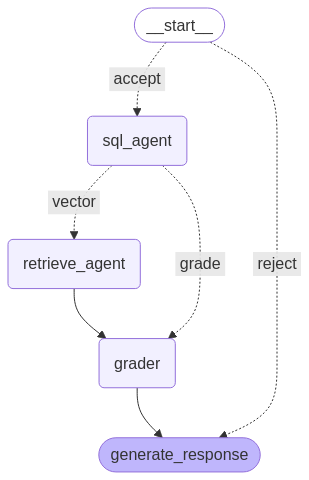

In [247]:
#checkpointer = MemorySaver()

# graph = workflow.compile(checkpointer=checkpointer)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [248]:
print(tool_call_result)

[[10, "Apple", "iPhone 13 Mini", 999, "Out of Stock"]]


In [249]:
import uuid
inputs = "Hello, what is the price of the iPhone 13 Pro?"

In [251]:
prompt = {
    "messages": [HumanMessage(content=inputs)],
    "tool_call_result": [],
    "grader_score": "",
    "justify": "",
    "retrieved_content": []
    }
# config = {"configurable": {"thread_id": "12346789"}}

for output, metadata in graph.stream(prompt, stream_mode="messages"):
    if metadata['langgraph_node'] == 'generate_response':
        print(output.content, end='', flush=True)
    # # print(output.content, end='', flush=True)
    # print(output.content, end='', flush=True)
# async for output, _ in graph.astream(prompt, config, stream_mode="messages"):
#     # if not tool_msg_received:
#     #     buffer.append(output)
#     #     if isinstance(output, ToolMessage):
#     #         tool_msg_received = True
#     #         buffer.clear()
#     print(output.content, end='', flush=True)



['Brand: Apple\nModel: iPhone 13 Mini\nPrice: 999\nStock_Status: Out of Stock', 'Brand: Apple\nModel: iPhone 11 Pro Max\nPrice: 1399\nStock_Status: In Stock', 'Brand: Apple\nModel: iPhone 14 Pro Max\nPrice: 1599\nStock_Status: In Stock', 'Brand: Apple\nModel: iPhone 13\nPrice: 1099\nStock_Status: In Stock']
Unfortunately, I couldn't find any information about the iPhone 13 Pro in our database. However, here are some other options that might interest you:

| Brand | Model | Price | Stock Status |
| --- | --- | --- | --- |
| Apple | iPhone 11 Pro Max | $1399 | In Stock |
| Apple | iPhone 14 Pro Max | $1599 | In Stock |
| Apple | iPhone 13 Mini | $999 | Out of Stock |
| Apple | iPhone 13 | $1099 | In Stock |

If you're interested in the iPhone 13, it's available for purchase. If you'd like to consider other options, I can provide more information about the iPhone 11 Pro Max or iPhone 14 Pro Max.